# Automated astrolabe builder


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Basic parameters

In [2]:
latitude = 30 # degrees N

In [3]:
almucantar_spacing = 2 # degrees
azimuth_spacing = 10 # degrees

equinox_day = 31+28+20 # Date of equinox

mater_gap_width = 0.1 # Projection plane units
mater_ring_width = 0.5 # Projection plane units

latitude_spacing = 10 # degrees
longitude_spacing = 360/24 # degrees
min_celestial_latitude = -30 # degrees N

solar_inclination = 23.4 # degrees
ecliptic_halfband = 5 # degrees

min_visible_mag = 4 # visible magnitude

compensate_ecliptic = True # Compensate ecliptic on rete for equation of time

In [4]:
points_per_circle = 100

## Convenience functions

In [5]:
def spherical_to_projection(x,y,z):
    '''Convert cartesian coordinates on the unit sphere to projection plane'''
    return (2*x/(1+z),2*y/(1+z))

In [6]:
def latlon_to_projection(lat,lon):
    '''Convert spherical coordiantes on the unit sphere to projection plane'''
    return spherical_to_projection(np.cos(lon*np.pi/180)*np.cos(lat*np.pi/180),
                                   np.sin(lon*np.pi/180)*np.cos(lat*np.pi/180),
                                   np.sin(lat*np.pi/180))

In [7]:
def solve_ellipse_angle_plus(A,B,C):
    '''Solve A = B*cos(x) + C*sin(x)'''
    return 2*np.arctan((C+np.sqrt(C**2+B**2-A**2))/(A+B))
def solve_ellipse_angle_minus(A,B,C):
    '''Solve A = B*cos(x) + C*sin(x)'''
    return 2*np.arctan((C-np.sqrt(C**2+B**2-A**2))/(A+B))

In [8]:
def eq_of_time(D):
    '''Compute equation of time (minutes) for day D
    
    Source https://en.wikipedia.org/wiki/Equation_of_time
    '''
    M=6.24004077 + 0.01720197*D
    dT = -7.659 * np.sin(M) + 9.863 * np.sin(2*M + 3.5932)
    return dT

In [9]:
def sun_ra(n):
    '''Compute right ascension (in radians) of the sun from its day n past 1 January 2000.
    
    Source https://en.wikipedia.org/wiki/Position_of_the_Sun
    '''
    L=280.460 +0.9856003*n
    g=357.528+0.9856003*n
    lam=L + 1.915*np.sin(g*np.pi/180)+0.02*np.sin(2*np.pi/180*g)
    eps=23.439+0.00000004*n
    ra=np.arctan2(np.cos(eps*np.pi/180)*np.sin(lam*np.pi/180),np.cos(lam*np.pi/180))
    return ra

## Draw rete

Ecliptic, inclination is in the `yz`-plane.
Second cell generates tick marks

In [10]:
angles=np.linspace(0,2*np.pi,points_per_circle)
xs=np.cos(angles)
ys=np.sin(angles)*np.cos(solar_inclination*np.pi/180)
zs=np.sin(angles)*np.sin(solar_inclination*np.pi/180)
ecliptic_pts=[spherical_to_projection(x,y,z) for (x,y,z) in zip(xs,ys,zs)]

In [11]:
month_days=[31,28,31,30,31,30,31,31,30,31,30,31]
month_names=['J','F','M','A','M','J','J','A','S','O','N','D']
month_ticks=[]
for month in range(12):
    day_number = sum([md for j,md in enumerate(month_days) if j < month])
    tick_angle = (day_number-equinox_day)/365*2*np.pi
    x1=np.cos(tick_angle)
    y1=np.sin(tick_angle)*np.cos(solar_inclination*np.pi/180)
    z1=np.sin(tick_angle)*np.sin(solar_inclination*np.pi/180)
    x2=np.cos(tick_angle)
    y2=np.sin(tick_angle)*np.cos(solar_inclination*np.pi/180)
    z2=np.sin(tick_angle)*np.sin(solar_inclination*np.pi/180)-np.sin(ecliptic_halfband*np.pi/180)
    month_ticks.append([spherical_to_projection(x1,y1,z1),
                        spherical_to_projection(x2,y2,z2)])

In [12]:
ecliptic_ticks=[]
for tick_angle_offset in np.linspace(0,2*np.pi,int(365/5)+1):
    tick_angle = tick_angle_offset - equinox_day/365*2*np.pi
    x1=np.cos(tick_angle)
    y1=np.sin(tick_angle)*np.cos(solar_inclination*np.pi/180)
    z1=np.sin(tick_angle)*np.sin(solar_inclination*np.pi/180)+np.sin(ecliptic_halfband*np.pi/180)
    x2=np.cos(tick_angle)
    y2=np.sin(tick_angle)*np.cos(solar_inclination*np.pi/180)
    z2=np.sin(tick_angle)*np.sin(solar_inclination*np.pi/180)
    ecliptic_ticks.append([spherical_to_projection(x1,y1,z1),
                          spherical_to_projection(x2,y2,z2)])
for month in range(12):
    for day in range(0,month_days[month],5):
        day_number = sum([md for j,md in enumerate(month_days) if j < month]) + day
        tick_angle = (day_number-equinox_day)/365*2*np.pi
        x1=np.cos(tick_angle)
        y1=np.sin(tick_angle)*np.cos(solar_inclination*np.pi/180)
        z1=np.sin(tick_angle)*np.sin(solar_inclination*np.pi/180)
        x2=np.cos(tick_angle)
        y2=np.sin(tick_angle)*np.cos(solar_inclination*np.pi/180)
        z2=np.sin(tick_angle)*np.sin(solar_inclination*np.pi/180)-np.sin(ecliptic_halfband/2*np.pi/180)
        ecliptic_ticks.append([spherical_to_projection(x1,y1,z1),
                              spherical_to_projection(x2,y2,z2)])

Import and project stars.
Source: [https://github.com/astronexus/HYG-Database]

In [13]:
df=pd.read_csv('hygdata_v3.csv')
df[df['mag']<min_visible_mag]

,id,hip,hd,hr,gl,bf,proper,ra,dec,dist,...,bayer,flam,con,comp,comp_primary,base,lum,var,var_min,var_max
0,0,NaN,NaN,NaN,NaN,NaN,Sol,0.000000,0.000000,0.0000,...,NaN,NaN,NaN,1,0,NaN,1.000000e+00,NaN,NaN,NaN
676,676,677,358,15,NaN,21Alp And,Alpheratz,0.139791,29.090432,29.7442,...,Alp,21,And,1,676,NaN,1.144986e+02,Alp,2.083,2.063
744,744,746,432,21,Gl 8,11Bet Cas,Caph,0.152887,59.149780,16.7842,...,Bet,11,Cas,1,744,NaN,3.006076e+01,Bet,2.303,2.263
763,763,765,496,25,Gl 9.1,Eps Phe,NaN,0.156836,-45.747426,44.2087,...,Eps,NaN,Phe,1,763,NaN,4.777492e+01,NaN,NaN,NaN
1065,1065,1067,886,39,NaN,88Gam Peg,Algenib,0.220598,15.183596,120.0480,...,Gam,88,Peg,1,1065,NaN,9.264031e+02,Gam,2.846,2.816
1559,1559,1562,1522,74,NaN,8Iot Cet,NaN,0.323799,-8.823921,84.1751,...,Iot,8,Cet,1,1559,NaN,2.324877e+02,NaN,NaN,NaN
2016,2016,2021,2151,98,Gl 19,Bet Hyi,NaN,0.427916,-77.254247,7.4588,...,Bet,NaN,Hyi,1,2016,NaN,3.607447e+00,NaN,NaN,NaN
2069,2069,2072,2262,100,Gl 20,Kap Phe,NaN,0.436716,-43.679829,23.8095,...,Kap,NaN,Phe,1,2069,NaN,1.323122e+01,NaN,NaN,NaN
2076,2076,2081,2261,99,NaN,Alp Phe,Ankaa,0.438056,-42.305981,25.9740,...,Alp,NaN,Phe,1,2076,NaN,6.444660e+01,NaN,NaN,NaN
2914,2914,2920,3360,153,NaN,17Zet Cas,NaN,0.616188,53.896909,181.8182,...,Zet,17,Cas,1,2914,NaN,9.620552e+02,NaN,NaN,NaN


In [14]:
star_pts=[]
for row in df[df['mag']<min_visible_mag].iterrows():
    if row[1]['id'] > 0:
        ra=row[1]['ra']*360/24.
        dec=row[1]['dec']
        if dec > min_celestial_latitude:
            x=np.cos(ra*np.pi/180)*np.cos(dec*np.pi/180)
            y=np.sin(ra*np.pi/180)*np.cos(dec*np.pi/180)
            z=np.sin(dec*np.pi/180)
            pt=spherical_to_projection(x,y,z)
            star_pts.append((pt[0],pt[1],row[1]['mag']))

Celestial latitudes and longitudes

In [15]:
angles=np.linspace(0,2*np.pi,points_per_circle)
xs=np.cos(angles)
ys=np.sin(angles)
z=0
equator_pts=[spherical_to_projection(x,y,z) for (x,y) in zip(xs,ys)]

latitudes_pts=[]
for lat in range(90,min_celestial_latitude-1,-latitude_spacing):
    xs=np.cos(angles)*np.cos(lat*np.pi/180)
    ys=np.sin(angles)*np.cos(lat*np.pi/180)
    z=np.sin(lat*np.pi/180)
    latitudes_pts.append([spherical_to_projection(x,y,z) for (x,y) in zip(xs,ys)])
longitudes_pts=[]
for longitude in np.arange(0,360,longitude_spacing):
    xs=[0,np.cos(longitude*np.pi/180)*np.cos(lat*np.pi/180)]
    ys=[0,np.sin(longitude*np.pi/180)*np.cos(lat*np.pi/180)]
    zs=[0,np.sin(lat*np.pi/180)]
    longitudes_pts.append([spherical_to_projection(x,y,z) for (x,y,z) in zip(xs,ys,zs)])

Outer rete ring and Mater angle and date scales:

* Innermost Julian date
* Next: Month/day
* Next: Time in quarters
* Outer: Angle in degrees

In [16]:
rete_pts=[]
mater_pts=[]

# Rete rings
inner_radius=2*np.cos(np.pi/180*min_celestial_latitude)/(1+np.sin(np.pi/180*min_celestial_latitude))
inner_1_radius=inner_radius+mater_ring_width/2
middle_radius=inner_radius+mater_ring_width
middle_tick_radius=middle_radius+mater_ring_width/2
middle_tick_1_radius=middle_radius+mater_ring_width*3/4
rete_edge_radius=middle_radius+mater_ring_width

# Mater rings
hour_radius=rete_edge_radius+mater_gap_width
hour_tick_radius=hour_radius+mater_ring_width/2
outer_radius=hour_radius+mater_ring_width
outermost_radius=outer_radius+mater_ring_width
outermost_5_radius=outermost_radius-mater_ring_width/2
outermost_1_radius=outermost_radius-mater_ring_width/4

# Rings
angles=np.linspace(0,2*np.pi,points_per_circle)
xs=inner_radius*np.cos(angles)
ys=inner_radius*np.sin(angles)
rete_pts.append(list(zip(xs,ys)))
xs=middle_radius*np.cos(angles)
ys=middle_radius*np.sin(angles)
rete_pts.append(list(zip(xs,ys)))
xs=rete_edge_radius*np.cos(angles)
ys=rete_edge_radius*np.sin(angles)
rete_pts.append(list(zip(xs,ys)))

xs=hour_radius*np.cos(angles)
ys=hour_radius*np.sin(angles)
mater_pts.append(list(zip(xs,ys)))
xs=outer_radius*np.cos(angles)
ys=outer_radius*np.sin(angles)
mater_pts.append(list(zip(xs,ys)))
xs=outermost_radius*np.cos(angles)
ys=outermost_radius*np.sin(angles)
mater_pts.append(list(zip(xs,ys)))

# Right ascension ticks, hours
for tick_angle_offset in np.linspace(0,2*np.pi,24+1):
    tick_angle = tick_angle_offset# - equinox_day/365*2*np.pi

    x1=inner_radius*np.cos(tick_angle)
    y1=inner_radius*np.sin(tick_angle)
    x2=middle_radius*np.cos(tick_angle)
    y2=middle_radius*np.sin(tick_angle)
    rete_pts.append([(x1,y1),(x2,y2)])

# Right ascension ticks, ten minutes
for tick_angle_offset in np.linspace(0,2*np.pi,24*6+1):
    tick_angle = tick_angle_offset# - equinox_day/365*2*np.pi

    x1=inner_1_radius*np.cos(tick_angle)
    y1=inner_1_radius*np.sin(tick_angle)
    x2=middle_radius*np.cos(tick_angle)
    y2=middle_radius*np.sin(tick_angle)
    rete_pts.append([(x1,y1),(x2,y2)])

# Month ticks
for month in range(12):
    day_number = sum([md for j,md in enumerate(month_days) if j < month])
    if compensate_ecliptic:
        tick_angle = sun_ra(day_number)
    else:
        tick_angle = (day_number-equinox_day)/365*2*np.pi
    x1=middle_radius*np.cos(tick_angle)
    y1=middle_radius*np.sin(tick_angle)
    x2=rete_edge_radius*np.cos(tick_angle)
    y2=rete_edge_radius*np.sin(tick_angle)
    rete_pts.append([(x1,y1),(x2,y2)])

# Day-of-month ticks
for month in range(12):
    for day in range(0,month_days[month],5):
        day_number = sum([md for j,md in enumerate(month_days) if j < month]) + day
        if compensate_ecliptic:
            tick_angle = sun_ra(day_number)
        else:
            tick_angle = (day_number-equinox_day)/365*2*np.pi
        x1=middle_tick_radius*np.cos(tick_angle)
        y1=middle_tick_radius*np.sin(tick_angle)
        x2=rete_edge_radius*np.cos(tick_angle)
        y2=rete_edge_radius*np.sin(tick_angle)
        rete_pts.append([(x1,y1),(x2,y2)])
    for day in range(0,month_days[month]):
        day_number = sum([md for j,md in enumerate(month_days) if j < month]) + day
        if compensate_ecliptic:
            tick_angle = sun_ra(day_number)
        else:
            tick_angle = (day_number-equinox_day)/365*2*np.pi
        x1=middle_tick_1_radius*np.cos(tick_angle)
        y1=middle_tick_1_radius*np.sin(tick_angle)
        x2=rete_edge_radius*np.cos(tick_angle)
        y2=rete_edge_radius*np.sin(tick_angle)
        rete_pts.append([(x1,y1),(x2,y2)])
        
# Hour ticks
for tick_angle in np.linspace(0,2*np.pi,24+1):
    x1=hour_radius*np.cos(tick_angle)
    y1=hour_radius*np.sin(tick_angle)
    x2=outer_radius*np.cos(tick_angle)
    y2=outer_radius*np.sin(tick_angle)
    mater_pts.append([(x1,y1),(x2,y2)])

# Quarter ticks
for tick_angle in np.linspace(0,2*np.pi,24*4+1):
    x1=hour_tick_radius*np.cos(tick_angle)
    y1=hour_tick_radius*np.sin(tick_angle)
    x2=outer_radius*np.cos(tick_angle)
    y2=outer_radius*np.sin(tick_angle)
    mater_pts.append([(x1,y1),(x2,y2)])

# Angle ticks
for tick_angle in np.linspace(0,2*np.pi,int(360/10)+1):
    x1=outer_radius*np.cos(tick_angle)
    y1=outer_radius*np.sin(tick_angle)
    x2=outermost_radius*np.cos(tick_angle)
    y2=outermost_radius*np.sin(tick_angle)
    mater_pts.append([(x1,y1),(x2,y2)])
for tick_angle in np.linspace(0,2*np.pi,int(360/5)+1):
    x1=outermost_5_radius*np.cos(tick_angle)
    y1=outermost_5_radius*np.sin(tick_angle)
    x2=outermost_radius*np.cos(tick_angle)
    y2=outermost_radius*np.sin(tick_angle)
    mater_pts.append([(x1,y1),(x2,y2)])
for tick_angle in np.linspace(0,2*np.pi,360+1):
    x1=outermost_1_radius*np.cos(tick_angle)
    y1=outermost_1_radius*np.sin(tick_angle)
    x2=outermost_radius*np.cos(tick_angle)
    y2=outermost_radius*np.sin(tick_angle)
    mater_pts.append([(x1,y1),(x2,y2)])

Render

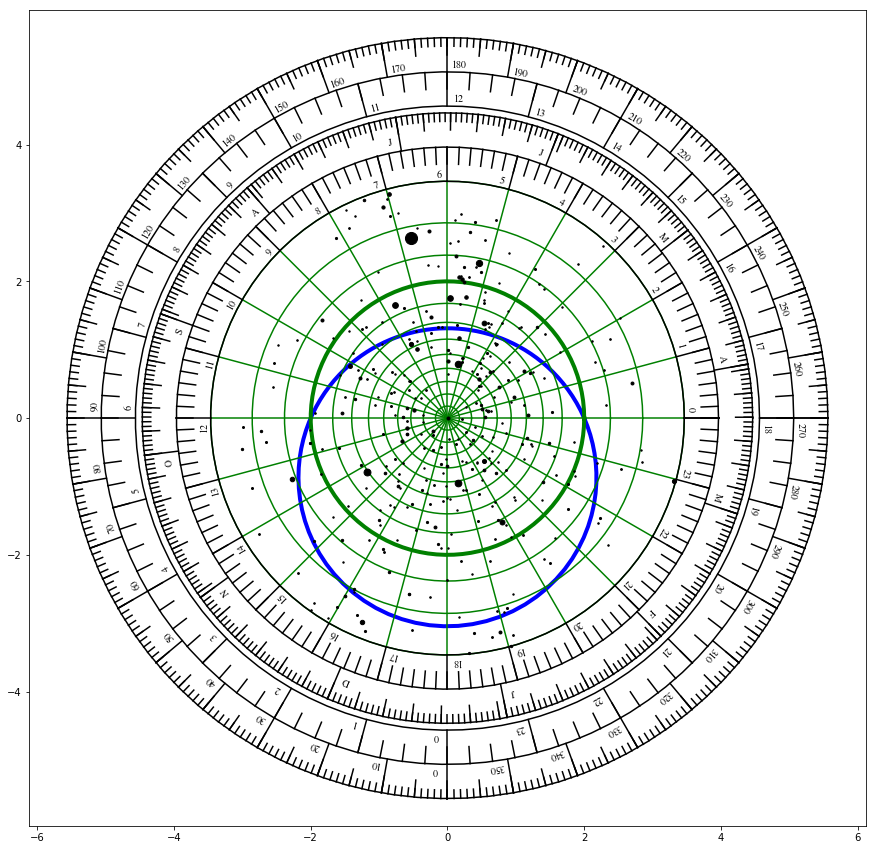

In [17]:
plt.figure(figsize=(15,15))
plt.plot([p[0] for p in ecliptic_pts],
        [p[1] for p in ecliptic_pts], 'b',linewidth=4)
#for ecliptic_tick in ecliptic_ticks:
#    plt.plot([p[0] for p in ecliptic_tick],
#        [p[1] for p in ecliptic_tick], 'r')
#for month_tick in month_ticks:
#    plt.plot([p[0] for p in month_tick],
#        [p[1] for p in month_tick], 'k')
for latitude_pts in latitudes_pts:
    plt.plot([p[0] for p in latitude_pts],
        [p[1] for p in latitude_pts], 'g')
for longitude_pts in longitudes_pts:
    plt.plot([p[0] for p in longitude_pts],
        [p[1] for p in longitude_pts], 'g')
plt.plot([p[0] for p in equator_pts],
        [p[1] for p in equator_pts], 'g',linewidth=4)
for rete_tick_pts in rete_pts:
    plt.plot([p[0] for p in rete_tick_pts],
        [p[1] for p in rete_tick_pts], 'k')
for mater_tick_pts in mater_pts:
    plt.plot([p[0] for p in mater_tick_pts],
        [p[1] for p in mater_tick_pts], 'k')

for ra in range(0,24):
    angle=-(ra+6)*15
    plt.text(-(inner_radius+0.1)*np.sin((angle-2)*np.pi/180), 
             -(inner_radius+0.1)*np.cos((angle-2)*np.pi/180), 
             str(ra),rotation=180-angle,ha='center',va='center',fontname='FreeSerif')

for angle in range(0,360,10):
    plt.text(-(outer_radius+0.1)*np.sin((angle+2)*np.pi/180), 
             -(outer_radius+0.1)*np.cos((angle+2)*np.pi/180), 
             str(angle),rotation=180-angle,ha='center',va='center',fontname='FreeSerif')

for hour in range(0,24):
    angle=-(hour+6)*15
    plt.text((hour_radius+0.1)*np.cos((angle-2)*np.pi/180), 
             (hour_radius+0.1)*np.sin((angle-2)*np.pi/180), 
             str(hour),rotation=angle-90,ha='center',va='center',fontname='FreeSerif')

for month in range(12):
    day_number = sum([md for j,md in enumerate(month_days) if j < month])
    if compensate_ecliptic:
        angle = sun_ra(day_number)*180/np.pi
    else:
        angle = (day_number-equinox_day)/365*360
    plt.text((middle_radius+0.15)*np.cos((angle+2)*np.pi/180), 
             (middle_radius+0.15)*np.sin((angle+2)*np.pi/180), 
             month_names[month],rotation=angle-90,ha='center',va='center',fontname='FreeSerif')
    
for star_pt in star_pts:
    plt.plot(star_pt[0],star_pt[1],'k.',markersize=4*1.5**(3-star_pt[2]))
plt.axis('equal')
if compensate_ecliptic:
    plt.savefig('rete_compensated.svg')
else:
    plt.savefig('rete.svg')

## Draw tympan

Almucantars drawn in `yz`-plane

In [18]:
angles=np.linspace(0,2*np.pi,points_per_circle)

almucantars_pts=[]
for elevation in range(0,90,almucantar_spacing):
    xs=np.cos(angles)*np.cos(elevation*np.pi/180)
    ys=np.sin(angles)*np.cos(elevation*np.pi/180)*np.cos((90-latitude)*np.pi/180)+np.sin((90-latitude)*np.pi/180)*np.sin(elevation*np.pi/180)
    zs=np.sin(elevation*np.pi/180)*np.cos((90-latitude)*np.pi/180)-np.sin((90-latitude)*np.pi/180)*np.sin(angles)*np.cos(elevation*np.pi/180)
    almucantars_pts.append([spherical_to_projection(x,y,z) for (x,y,z) in zip(xs,ys,zs)])

Azimuths

In [19]:
angles=np.linspace(0,180,int(points_per_circle/2))

azimuths_pts=[]
for azimuth in range(0,180,azimuth_spacing):
    xs=np.cos(azimuth*np.pi/180)*np.cos(angles*np.pi/180)
    ys=np.sin(azimuth*np.pi/180)*np.cos(angles*np.pi/180)*np.cos((90-latitude)*np.pi/180)+np.sin((90-latitude)*np.pi/180)*np.sin(angles*np.pi/180)
    zs=np.sin(angles*np.pi/180)*np.cos((90-latitude)*np.pi/180)-np.sin((90-latitude)*np.pi/180)*np.sin(azimuth*np.pi/180)*np.cos(angles*np.pi/180)
    azimuths_pts.append([spherical_to_projection(x,y,z) for (x,y,z) in zip(xs,ys,zs)])

Unequal hours

These are generated by rotating the horizon about the local north vector.  
Note that the horizon gets recomputed each time to keep the curves from getting too long

In [20]:
local_north=[0,
             -np.sin(latitude*np.pi/180),
             np.cos(latitude*np.pi/180)]

unequal_hours_pts=[]
for hour in range(0,13):
    rotation=hour*15*np.pi/180

    angles=np.linspace(np.pi+solve_ellipse_angle_plus(-np.sin(min_celestial_latitude*np.pi/180),
                                                      np.sin(latitude*np.pi/180)*np.sin(rotation),
                                                     -np.sin(latitude*np.pi/180)**2*np.cos(latitude*np.pi/180)*(1-np.cos(rotation))
                                                     -np.cos(latitude*np.pi/180)*(np.cos(rotation)+np.cos(latitude*np.pi/180)**2*(1-np.cos(rotation)))),
                       3*np.pi/2,
                       points_per_circle)

    # Horizon
    xsh=np.cos(angles)
    ysh=np.sin(angles)*np.sin(latitude*np.pi/180)
    zsh=-np.cos(latitude*np.pi/180)*np.sin(angles)
    
    xs=xsh*(np.cos(rotation)) +ysh*(-local_north[2]*np.sin(rotation)) + zsh*(local_north[1]*np.sin(rotation))
    ys=xsh*(local_north[2]*np.sin(rotation)) +ysh*(np.cos(rotation)+local_north[1]**2*(1-np.cos(rotation))) + zsh*(local_north[1]*local_north[2]*(1-np.cos(rotation)))
    zs=xsh*(-local_north[1]*np.sin(rotation)) +ysh*(local_north[1]*local_north[2]*(1-np.cos(rotation))) + zsh*(np.cos(rotation)+local_north[2]**2*(1-np.cos(rotation)))
    unequal_hours_pts.append([spherical_to_projection(x,y,z) for (x,y,z) in zip(xs,ys,zs)])

Render

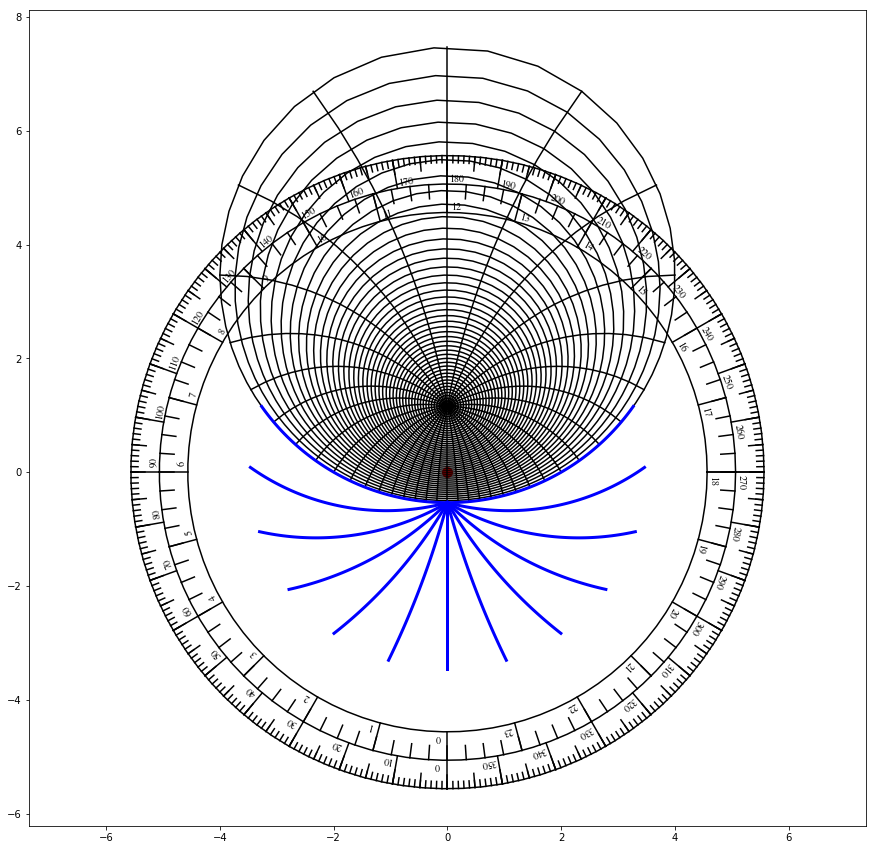

In [21]:
plt.figure(figsize=(15,15))
plt.plot(0,0,'r.',markersize=20)

for almucantar_pts in almucantars_pts:
    plt.plot([p[0] for p in almucantar_pts],
        [p[1] for p in almucantar_pts], 'k')
for azimuth_pts in azimuths_pts:
    plt.plot([p[0] for p in azimuth_pts],
        [p[1] for p in azimuth_pts], 'k')

for unequal_hour_pts in unequal_hours_pts:
    plt.plot([p[0] for p in unequal_hour_pts],
        [p[1] for p in unequal_hour_pts], 'b',linewidth=3)
    
for mater_tick_pts in mater_pts:
    plt.plot([p[0] for p in mater_tick_pts],
        [p[1] for p in mater_tick_pts], 'k')
    
for angle in range(0,360,10):
    plt.text(-(outer_radius+0.1)*np.sin((angle+2)*np.pi/180), 
             -(outer_radius+0.1)*np.cos((angle+2)*np.pi/180), 
             str(angle),rotation=180-angle,ha='center',va='center',fontname='FreeSerif')

for hour in range(0,24):
    angle=-(hour+6)*15
    plt.text((hour_radius+0.1)*np.cos((angle-2)*np.pi/180), 
             (hour_radius+0.1)*np.sin((angle-2)*np.pi/180), 
             str(hour),rotation=angle-90,ha='center',va='center',fontname='FreeSerif')

plt.axis('equal')
plt.savefig('tympan_'+str(latitude)+'.svg')

## Draw mater back

Compute equation of time

In [22]:
dt_pts=[]

for tick_angle in np.linspace(0,2*np.pi,365+1):
    D = tick_angle*365/(2*np.pi)+equinox_day
    dT = eq_of_time(D)
    dt_pts.append(((-dT/20+2)*np.cos(tick_angle),
                    (-dT/20+2)*np.sin(tick_angle)))
    
angles=np.linspace(0,2*np.pi,points_per_circle)
dt0_xs=2*np.cos(angles)
dt0_ys=2*np.sin(angles)

dt_ticks=[]
for dt in np.linspace(-20,20,21):
    dt_xs=(dt/20+2)*np.cos(angles)
    dt_ys=(dt/20+2)*np.sin(angles)
    dt_ticks.append([dt_xs,dt_ys])

Render

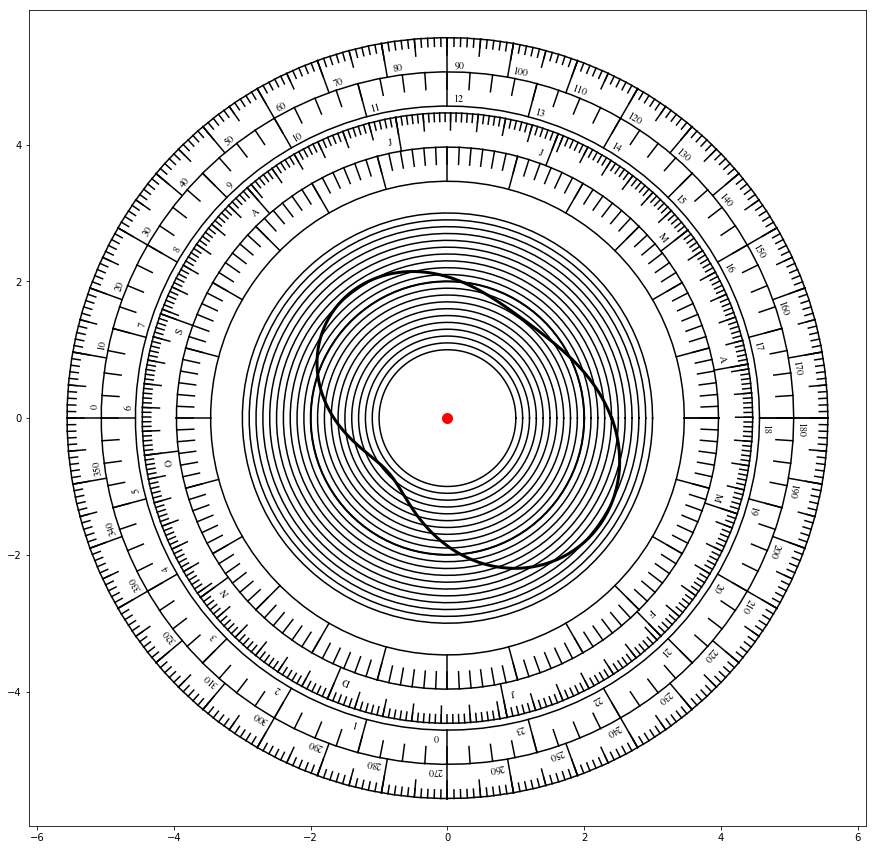

In [23]:
plt.figure(figsize=(15,15))

plt.plot(0,0,'r.',markersize=20)

plt.plot(dt0_xs,dt0_ys,'k',linewidth=2)

for dt_tick in dt_ticks:
    plt.plot(dt_tick[0],dt_tick[1],'k')

plt.plot([dt[0] for dt in dt_pts],
        [dt[1] for dt in dt_pts],'k',linewidth=3)

for mater_tick_pts in mater_pts:
    plt.plot([p[0] for p in mater_tick_pts],
        [p[1] for p in mater_tick_pts], 'k')
    
for rete_tick_pts in rete_pts:
    plt.plot([p[0] for p in rete_tick_pts],
        [p[1] for p in rete_tick_pts], 'k')
    
for angle in range(0,360,10):
    plt.text(-(outer_radius+0.1)*np.cos((angle+2)*np.pi/180), 
             (outer_radius+0.1)*np.sin((angle+2)*np.pi/180), 
             str(angle),rotation=90-angle,ha='center',va='center',fontname='FreeSerif')

for hour in range(0,24):
    angle=-(hour+6)*15
    plt.text((hour_radius+0.1)*np.cos((angle-2)*np.pi/180), 
             (hour_radius+0.1)*np.sin((angle-2)*np.pi/180), 
             str(hour),rotation=angle-90,ha='center',va='center',fontname='FreeSerif')

for month in range(12):
    day_number = sum([md for j,md in enumerate(month_days) if j < month])
    if compensate_ecliptic:
        angle = sun_ra(day_number)*180/np.pi
    else:
        angle = (day_number-equinox_day)/365*360
    plt.text((middle_radius+0.15)*np.cos((angle+2)*np.pi/180), 
             (middle_radius+0.15)*np.sin((angle+2)*np.pi/180), 
             month_names[month],rotation=angle-90,ha='center',va='center',fontname='FreeSerif')
    
plt.axis('equal')
plt.savefig('materback_'+str(latitude)+'.svg')